In [4]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

# noinspection PyUnresolvedReferences
from tensorflow.keras.preprocessing.text import Tokenizer
# noinspection PyUnresolvedReferences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from helper import *

In [56]:
data_path = "../data/processed_data_temp.csv"
pickle_path = "../data/data.pickle"

model_name = "like_model_ss"

# with open(pickle_path, "rb") as f:
#     data = pickle.load(f)

df = pd.read_csv(data_path)
# drop id, source, date, time, views, forwards, containing_media
df = df.drop(columns=["id", "source", "date", "time", "views", "forwards", "containing_media", "sum"])
df = df.dropna()
crop_percent = 0.1
# select random crop_percent of data
df = df.sample(frac=crop_percent, random_state=42)
print(f"Data length: {len(df)}")
df.head()

Data length: 18726


C:\Users\yaros\AppData\Local\Temp\ipykernel_7056\1616627533.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,text,positive,mixed,negative
5348,"«Сі Цзіньпін каже, що готує Китай до війни. Св...",0.063175,0.00194,0.934885
109898,Коротше є змога закупити для війська різні бо...,0.995538,0.00000,0.004462
66838,"Центральний Парк. Манхеттен, Нью-Йорк\n\nНОВИНА",1.000000,0.00000,0.000000
155670,🇺🇦 Україна виборола першу медаль на чемпіонаті...,1.000000,0.00000,0.000000
132241,☃️Штормовий вітер та дощі: прогноз погоди в У...,0.937561,0.00000,0.062439


In [57]:
def filter_string_rows(df):
    data = []
    # Check if row[0] is a string
    for row in df.values:
        if isinstance(row[0], str):
            data.append(row)

    print(f"Data length: {len(data)}")
    return data

def clean_data(data):
    for i in range(len(data)):
        data[i][0] = clean_text(data[i][0])
        if i % 1000 == 0:
            print(f"Cleaning: {i + 1}/{len(data)}", end="\r")
    print(f"Cleaning: {len(data)}/{len(data)}")
    return data

def process_data(data):
    for i in range(len(data)):
        data[i][0] = replace_numbers(data[i][0])
        if i % 1000 == 0:
            print(f"Processing: {i + 1}/{len(data)}", end="\r")
    print(f"Processing: {len(data)}/{len(data)}")
    return data

def articles_answers_crop(data):
    articles = [row[0] for row in data]
    answers = [[float(value) for value in row[1:]] for row in data]
    return articles, answers


data = filter_string_rows(df)
articles, answers = articles_answers_crop(data)
print(f"Articles: {len(articles)}, Answers: {len(answers)}")
print(f"Example: {articles[0]}, {answers[0]}")

Data length: 18726
Articles: 18726, Answers: 18726
Example: «Сі Цзіньпін каже, що готує Китай до війни. Світ має сприймати його серйозно», – Foreign Affairs 

Там наголошують, що Сі заявив про намір ще на 7,2% збільшити оборонний бюджет, який і так вже вдвічі зріз за минулі 10 років. Також на ближніх до Тайваню землях будують бомбосховища, намагаються сформувати запаси зерна та створити осередки «Мобілізації національної оборони» по всій країні.

Подписаться | @uanovo⚡️ , [0.0631753948462177, 0.0019395954558049, 0.9348850096979772]


In [58]:
(train_articles, train_answers), (validation_articles, validation_answers) = split_data(articles, answers, 0.95)
print(f"Train: {len(train_articles)}, Validation: {len(validation_articles)}")

Train: 17789, Validation: 937


In [59]:
english_letters = "abcdefghijklmnopqrstuvwxyz"
ukrainian_letters = "абвгґдеєжзиіїйклмнопрстуфхцчшщьюя"
russian_letters = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя"
numbers = "0123456789"
punctuation = " .,:;!?\"'«»()[]{}<>-–—/\\|@#$%^&*№~`+=\t\n"
all_letters = english_letters + ukrainian_letters + russian_letters + numbers + punctuation
print(f"Letters: {len(all_letters)}")

Letters: 141


In [60]:
vocab_size = len(all_letters)
max_length = 1000
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

In [61]:
# make tokenizer vocabulary from all letters
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, char_level=True, filters="")
tokenizer.fit_on_texts(all_letters)
word_index = tokenizer.word_index
print(f"Word index length: {len(word_index)}")
print(f"Word index: {word_index}")

Word index length: 113
Word index: {'<OOV>': 1, 'а': 2, 'б': 3, 'в': 4, 'г': 5, 'д': 6, 'е': 7, 'ж': 8, 'з': 9, 'и': 10, 'й': 11, 'к': 12, 'л': 13, 'м': 14, 'н': 15, 'о': 16, 'п': 17, 'р': 18, 'с': 19, 'т': 20, 'у': 21, 'ф': 22, 'х': 23, 'ц': 24, 'ч': 25, 'ш': 26, 'щ': 27, 'ь': 28, 'ю': 29, 'я': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'w': 53, 'x': 54, 'y': 55, 'z': 56, 'ґ': 57, 'є': 58, 'і': 59, 'ї': 60, 'ё': 61, 'ъ': 62, 'ы': 63, 'э': 64, '0': 65, '1': 66, '2': 67, '3': 68, '4': 69, '5': 70, '6': 71, '7': 72, '8': 73, '9': 74, ' ': 75, '.': 76, ',': 77, ':': 78, ';': 79, '!': 80, '?': 81, '"': 82, "'": 83, '«': 84, '»': 85, '(': 86, ')': 87, '[': 88, ']': 89, '{': 90, '}': 91, '<': 92, '>': 93, '-': 94, '–': 95, '—': 96, '/': 97, '\\': 98, '|': 99, '@': 100, '#': 101, '$': 102, '%': 103, '^': 104, '&': 105, '*': 106, '№': 10

In [62]:
def letters_per_article(articles):
    # return min, max, mean
    lengths = [len(article) for article in articles]
    return min(lengths), max(lengths), sum(lengths) / len(lengths)

min_letters, max_letters, mean_letters = letters_per_article(articles)
print(f"Min letters: {min_letters}, Max letters: {max_letters}, Mean letters: {mean_letters}")

Min letters: 1, Max letters: 3885, Mean letters: 294.42390259532203


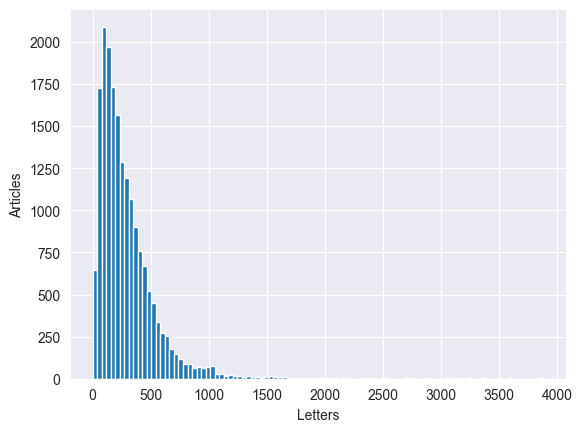

In [63]:
# plot distribution of letters per article
plt.hist([len(article) for article in articles], bins=100)
plt.xlabel("Letters")
plt.ylabel("Articles")
plt.show()

In [64]:
train_padded = pad_sequences(tokenizer.texts_to_sequences(train_articles),
                             maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_padded = pad_sequences(tokenizer.texts_to_sequences(validation_articles),
                                  maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(f"Train padded shape: {train_padded.shape}, Validation padded shape: {validation_padded.shape}")

Train padded shape: (17789, 1000), Validation padded shape: (937, 1000)


In [65]:
train_answers = np.array(train_answers)
validation_answers = np.array(validation_answers)

In [66]:
# print some examples
for i in range(5):
    print(f"Article: {train_articles[i]}")
    print(f"Article padded: {train_padded[i][:100]}...{train_padded[i][-100:]}")
    print(f"Answer: {train_answers[i]}")
    print()

Article: Чергове ракетне шоу КНДР. Кім Чен Ин провів випробування 4 Hwasal-2, щоб показати, якою може бути ядерна контратака. Запуск відбувся в той час, коли офіційні особи США і Південної Кореї брали участь у навчаннях, через можливу агресію комуністичного сусіда, – Reuters.

Times of Ukraine 
Article padded: [25  7 18  5 16  4  7 75 18  2 12  7 20 15  7 75 26 16 21 75 12 15  6 18
 76 75 12 59 14 75 25  7 15 75 10 15 75 17 18 16  4 59  4 75  4 10 17 18
 16  3 21  4  2 15 15 30 75 69 75 38 53 31 49 31 42 94 67 77 75 27 16  3
 75 17 16 12  2  9  2 20 10 77 75 30 12 16 29 75 14 16  8  7 75  3 21 20
 10 75 30  6]...[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Answer: [0.05172414 0.66540948 0.28286638]

Article:  Колаборант Сальдо ще не здох. 
Мої джерела підтверджують, що його вивезли у окупований Крим із підозрою на інсульт. 

Хз, 

In [72]:
import keras.layers as L

def create_model(vocab_size, embedding_dim, max_length):
    input = L.Input(shape=(max_length,))
    x = L.Embedding(vocab_size, embedding_dim)(input)
    # for i in range(3):
    #     x = L.Conv1D(32, 5, activation="relu")(x)
    #     x = L.MaxPooling1D(5)(x)
    x = L.LSTM(128)(x)
    x = L.Flatten()(x)
    # x = L.Dense(64, activation="relu")(x)
    x = L.Dense(32, activation="relu")(x)
    x = L.Dropout(0.1)(x)
    output = L.Dense(3, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model

model = create_model(vocab_size, 4, max_length)

loss = tf.keras.losses.KLDivergence()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ["accuracy"]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1000)]            0         
                                                                 
 embedding_18 (Embedding)    (None, 1000, 4)           564       
                                                                 
 lstm_9 (LSTM)               (None, 128)               68096     
                                                                 
 flatten_13 (Flatten)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 32)                4128      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 3)                 99 

In [73]:
epochs = 10
batch_size = 1024
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../models/{model_name}_checkpoint.h5",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

history = model.fit(
    train_padded, train_answers,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_padded, validation_answers),
    callbacks=[checkpoint_callback]
)

Epoch 1/10
18/18 [==============================] - 147s 8s/step - loss: 0.4477 - accuracy: 0.6153 - val_loss: 0.4261 - val_accuracy: 0.5880
Epoch 2/10
18/18 [==============================] - 162s 9s/step - loss: 0.4300 - accuracy: 0.6155 - val_loss: 0.3990 - val_accuracy: 0.5880
Epoch 3/10
 6/18 [=========>....................] - ETA: 1:55 - loss: 0.4066 - accuracy: 0.6146

KeyboardInterrupt: 

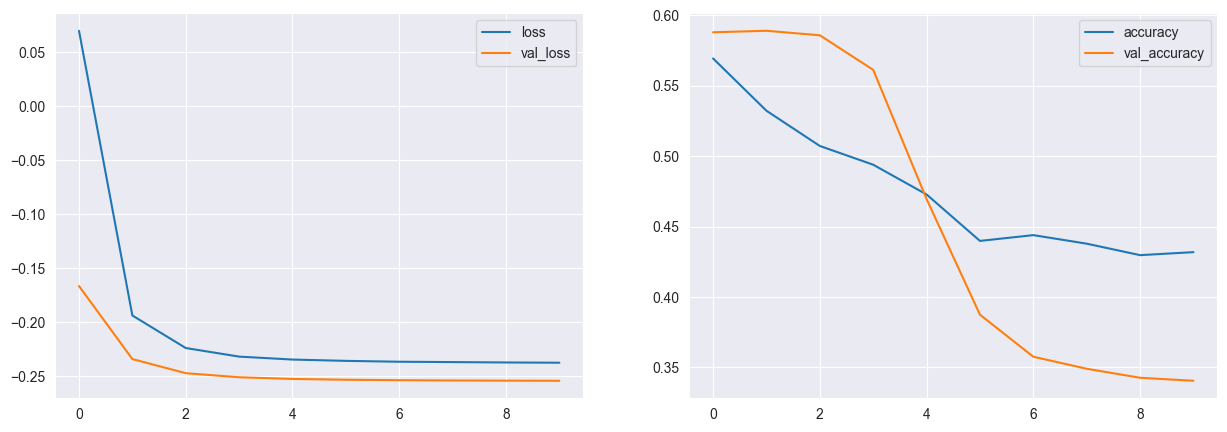

In [69]:
def plot_history(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()

    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()

def plot_history_as_subplots(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.legend()
    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.legend()
    plt.show()

plot_history_as_subplots(history)